#### Linear quadratic `state estimation`

Assume we have the following state transition and sensor equation

$$x_{t+1}=Ax_t+Bw_t, y_t=Cx_t+v_t, t=1,2,\cdots$$

where $w_t$ is `system noise`, and $v_t$ is `measurement noise`

We want to, given measurements $y_1, \cdots, y_T$ and $A, B, C$, `guess` the state sequence $x_1, \cdots, x_T$

Since we don't know the noise terms, one logical thing we can do is for our `guess` to minimize the sum of squares of norms of noise

$$\sum_{i=1}^T\|Cx_i-y_i\|^2 + \lambda \sum_{i=1}^{T-1}\|w_i\|^2, \text{s.t. } x_{t+1}=Ax_t+Bw_t$$

We can formulate as `constrained least squares`

$$\min \|\tilde{A}z-\tilde{b}\|^2, \text{s.t. } \tilde{C}z=\tilde{d}$$

where

$$z=(x_1,\cdots, x_T, w_1,\cdots, w_{T-1})$$

$$\begin{align*}\tilde{A}&=\begin{bmatrix}C_1 & & & & & \\  & \ddots & & & & & \\
 & & C_T & & & \\ & & & \sqrt{\lambda}I & & \\ & & & & \ddots & \\ & & & & & \sqrt{\lambda}I\end{bmatrix},\, \tilde{y}=\begin{bmatrix}y_1 \\ \vdots \\ y_T \\ 0 \\ \vdots \\ 0\end{bmatrix}\\
 \tilde{C}&=\begin{bmatrix}A_1 & -I & & & B_1 & & \\ & \ddots & \ddots & & & \ddots & \\ & & A_{T-1} & -I & & & B_{T-1}\end{bmatrix}
 \end{align*}$$

#### `2D example` with time-invariant A, B, and C

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

For this example we assume $A, B, C$ are time-invariant and

$$A=\begin{bmatrix}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}, \, B=\begin{bmatrix}0 & 0 \\ 0 & 0 \\ 1 & 0 \\ 0 & 1\end{bmatrix}, \, C=\begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}$$

(4, 100)
(2, 100)


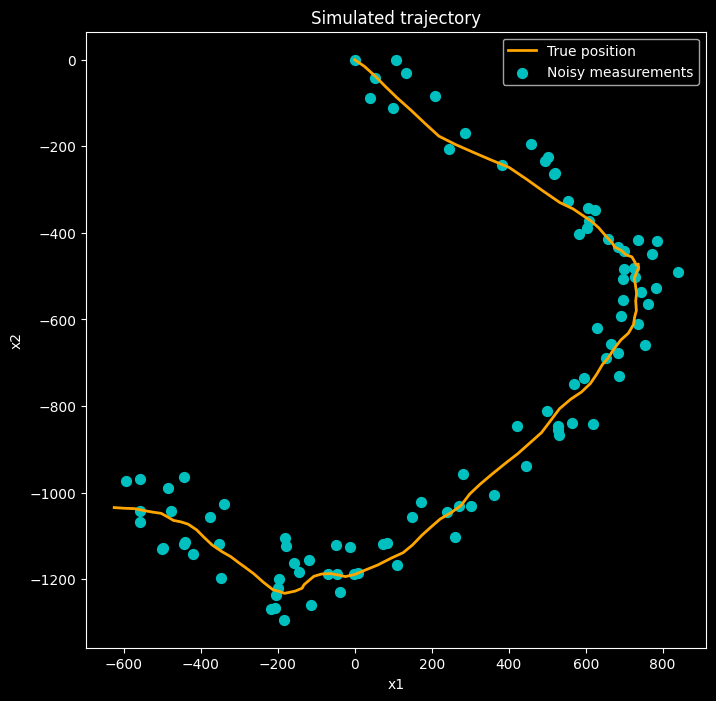

In [2]:
A = np.array([[1, 0, 1, 0],
              [0, 1, 0, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

B = np.array([[0, 0],
              [0, 0],
              [1, 0],
              [0, 1]])

C = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

def simulate_trajectory(A, B, C, num_steps=100, system_noise=1.0, meas_noise=5.0):
    x = np.zeros((4, num_steps))  # State (x1, x2, vx, vy), first 2 position, next 2 velocity
    y = np.zeros((2, num_steps))  # Measurement (x1, x2)

    x[:, 0] = [0, 0, 25, -15]

    np.random.seed(42)
    w = system_noise * np.random.randn(2, num_steps)
    v = meas_noise * np.random.randn(2, num_steps)

    for t in range(1, num_steps):
        x[:, t] = A @ x[:, t-1] + B @ w[:, t-1]
        y[:, t] = C @ x[:, t] + v[:, t]

    return x, y

num_steps = 100
x, y = simulate_trajectory(A, B, C, num_steps=num_steps, system_noise=5.0, meas_noise=50.0)
print(x.shape)
print(y.shape)

plt.figure(figsize=(8, 8))
plt.plot(x[0, :], x[1, :], label='True position', color='orange', linewidth=2)
plt.scatter(y[0, :], y[1, :], label='Noisy measurements', color='c', marker='o', s=50)
plt.title('Simulated trajectory')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

#### Formulate matrices for constrained least squares

In [3]:
def get_matrices(A, B, C, y, T, lambda_reg):
    n = np.shape(A)[0]  # Dim of state space (4), which is also np.shape(A)[1] and np.shape(C)[1]
    m = np.shape(B)[1]  # Dim of noise space (2)
    p = np.shape(C)[0]  # Dim of measurement space (2)
    print(f'dim of state space: {n}')
    print(f'dim of noise space: {m}')
    print(f'dim of measurement space: {p}')

    # np.kron(a, b) gives a composite array made of blocks of b scaled by a
    Atil = np.vstack([
        np.hstack([np.kron(np.eye(T), C), np.zeros((T*p, m*(T-1)))]),
        np.hstack([np.zeros((m*(T-1), n*T)), np.sqrt(lambda_reg) * np.eye(m*(T-1))])
    ])

    btil = np.vstack([y.T.flatten()[:, None], np.zeros((m*(T-1), 1))])

    Ctila = np.hstack([np.kron(np.eye(T-1), A), np.zeros((n*(T-1), n))])
    Ctilb = np.hstack([np.zeros((n*(T-1), n)), -np.eye(n*(T-1))])
    Ctil = np.hstack([Ctila + Ctilb, np.kron(np.eye(T-1), B)])

    dtil = np.zeros((n*(T-1), 1))

    return Atil, btil, Ctil, dtil

In [4]:
T = 100
lambda_reg = 1000

Atil, btil, Ctil, dtil = get_matrices(A, B, C, y, T, lambda_reg)

print("Atil shape:", Atil.shape)
print("btil shape:", btil.shape)
print("Ctil shape:", Ctil.shape)
print("dtil shape:", dtil.shape)

dim of state space: 4
dim of noise space: 2
dim of measurement space: 2
Atil shape: (398, 598)
btil shape: (398, 1)
Ctil shape: (396, 598)
dtil shape: (396, 1)


#### Solve constrained least squares

(598, 1)
(4, 100)


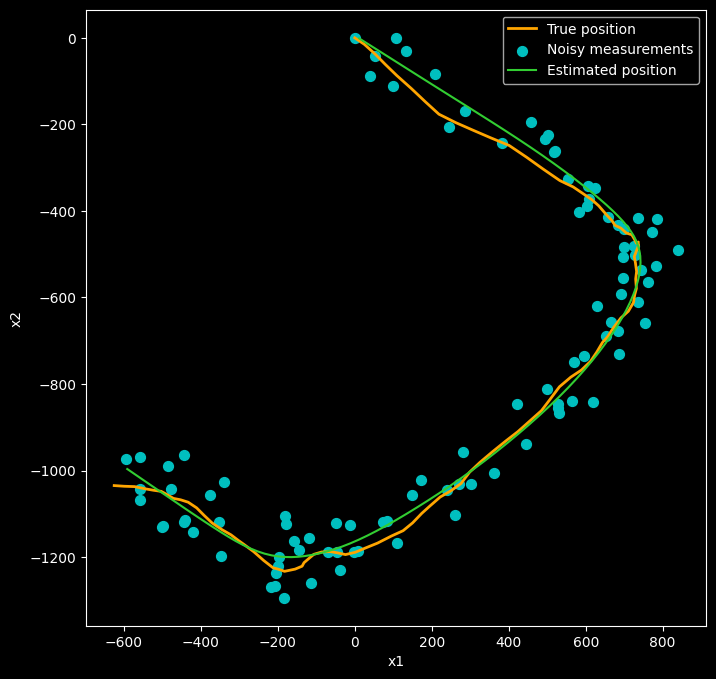

In [5]:
# This solver by Vince Bartle https://github.com/vbartle/VMLS-Companions/tree/master
# Based on Algorithm 16.2 in the book https://web.stanford.edu/~boyd/vmls/
def cls_solve(A, b, C, d):
    m, n = np.shape(A)
    p, _ = np.shape(C)

    Q, R = npl.qr(np.vstack([A, C]))
    Q1 = Q[:m, :]
    Q2 = Q[m:m+p, :]

    Qtil, Rtil = npl.qr(Q2.T)

    first = 2 * Qtil.T @ Q1.T @ b
    denom = first - 2 * npl.lstsq(Rtil.T, d, rcond=None)[0]
    w = npl.lstsq(Rtil, denom, rcond=None)[0]
    result = npl.lstsq(R, Q1.T @ b - Q2.T @ w / 2, rcond=None)[0]

    return result

z_est = cls_solve(Atil, btil, Ctil, dtil)
print(z_est.shape)

x_est = z_est[:C.shape[1] * T].reshape(T, -1).T
print(x_est.shape)

plt.figure(figsize=(8, 8))
plt.plot(x[0, :], x[1, :], label='True position', color='orange', linewidth=2)
plt.scatter(y[0, :], y[1, :], label='Noisy measurements', color='c', marker='o', s=50)
plt.plot(x_est[0,:], x_est[1, :], label='Estimated position', color='limegreen')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

#### `Kalman filter` and sequential update

The above linear quadratic state estimation is closely related to the Kalman filter, which comes from estimating state using both the state transition model and the sensor measurement

##### `Combining` measurements from two sensors

To start, assume that we have 2 sensors, each one with its own measurement mean $\mu$ and variance $\sigma^2$

$$(\mu_a, \sigma_a^2), (\mu_b, \sigma_b^2)$$

Could we `combine` these two to get a better measurement?

Yes indeed, as each reading represents a Gaussian and the product of two Gaussians can be expressed as

$$(\mu_{new}, \sigma_{new}^2) = \left(\mu_a + \frac{\sigma_a^2 (\mu_b - \mu_a)}{\sigma_a^2 + \sigma_b^2}, \ \sigma_a^2 - \frac{\sigma_a^4}{\sigma_a^2 + \sigma_b^2}\right)$$

or

$$(\mu_{new}, \sigma_{new}^2) = (\mu_a + k (\mu_b - \mu_a), \ \sigma_a^2 - k \sigma_a^2)$$

where

$$k = \frac{\sigma_a^2}{\sigma_a^2 + \sigma_b^2}$$

is called the `Kalman gain`

We can express $\mu_{new}$ as

$$\mu_{new} = (1 - k) \mu_a + k \mu_b$$

This is essentially a `linear interpolation` where $k$ determines the weight of each sensor

If we have `multivariate` measurement at each time step $t$, then we use vector form $\mu(t)$ and covariance matrix $\Sigma(t)$

##### What if we can only carry `one sensor`?

The idea of Kalman filter is that despite having only one real sensor, we could still get 2 different readings. One reading would come from the sensor itself

$$\mu_{a}(t), \Sigma_a(t)$$

and the second reading could be extrapolated from the previous reading

$$\mu_{a}(t-1), \Sigma_a(t-1)$$

The important thing is that state transformation often can be approximated as `linear`, which means it can be expressed as multiplication with a matrix $A$. With these requirements, the second reading would be

$$\mu_{v}(t), \Sigma_{v}(t) = A \mu_a(t-1), A \Sigma_a(t-1) A^T$$

##### Product of two `multivariate` Gaussians

We then have two "sensors" - the real one and the virtual one (which extrapolates data from the previous instant)

* $\mu_a(t), \Sigma_a(t)$
* $\mu_{v}(t), \Sigma_{v}(t) = A \mu_a(t-1), A \Sigma_a(t-1) A^T$

We now use the extension of

$$(\mu_{new}, \sigma_{new}^2) = (\mu_a + k (\mu_v - \mu_a), \ \sigma_a^2 - k \sigma_a^2)$$

where

$$k = \frac{\sigma_a^2}{\sigma_a^2 + \sigma_v^2}$$

to the `multivariate` case

From Petersen & Pedersen's matrix cookbook, the product of two multivariate Gaussians has a `covariance matrix` ($(t)$ dropped for clarity)

$$\begin{align*}
\Sigma_{new}&=\left(\Sigma_a^{-1}+\Sigma_v^{-1}\right)^{-1} \\
& \text{matrix inversion lemma} \\
&=\Sigma_a-\Sigma_a\left(\Sigma_a+\Sigma_v\right)^{-1}\Sigma_a \\
&=\Sigma_a-K\Sigma_a \\
&=\left(I-K\right)\Sigma_a
\end{align*}$$

where

$$K=\Sigma_a\left(\Sigma_a+\Sigma_v\right)^{-1}$$

is the `Kalman gain`

and a `mean` vector

$$\begin{align*}
\mu_{new}&=\Sigma_{new}\left(\Sigma_a^{-1}\mu_a+\Sigma_v^{-1}\mu_v\right) \\
&=\left(I-K\right)\Sigma_a\Sigma_a^{-1}\mu_a+\left(I-K\right)\Sigma_a\Sigma_v^{-1}\mu_v \\
&=\left(I-K\right)\mu_a+\left(I-\Sigma_a\left(\Sigma_a+\Sigma_v\right)^{-1}\right)\Sigma_a\Sigma_v^{-1}\mu_v \\
& \text{matrix inversion lemma} \\
&=\left(I-K\right)\mu_a+\left(I-\Sigma_a\left(\Sigma_a^{-1}-\Sigma_a^{-1}\left(\Sigma_v^{-1}+\Sigma_a^{-1}\right)^{-1}\Sigma_a^{-1}\right)\right)\Sigma_a\Sigma_v^{-1}\mu_v \\
&=\left(I-K\right)\mu_a+\left(I-\left(I-\left(\Sigma_v^{-1}+\Sigma_a^{-1}\right)^{-1}\Sigma_a^{-1}\right)\right)\Sigma_a\Sigma_v^{-1}\mu_v \\
&=\left(I-K\right)\mu_a+\left(\left(\Sigma_v^{-1}+\Sigma_a^{-1}\right)^{-1}\Sigma_a^{-1}\right)\Sigma_a\Sigma_v^{-1}\mu_v \\
&=\left(I-K\right)\mu_a+\left(\Sigma_v^{-1}+\Sigma_a^{-1}\right)^{-1}\Sigma_v^{-1}\mu_v \\
& \text{matrix inversion lemma} \\
&=\left(I-K\right)\mu_a+\left(\Sigma_v-\Sigma_v\left(\Sigma_a+\Sigma_v\right)^{-1}\Sigma_v\right)\Sigma_v^{-1}\mu_v \\
&=\left(I-K\right)\mu_a+\left(I-\Sigma_v\left(\Sigma_a+\Sigma_v\right)^{-1}\right)\mu_v \\
&=\left(I-K\right)\mu_a+\left(I-\left(\Sigma_a+\Sigma_v\right)\left(\Sigma_a+\Sigma_v\right)^{-1}+\Sigma_a\left(\Sigma_a+\Sigma_v\right)^{-1}\right)\mu_v \\
&=\left(I-K\right)\mu_a+\left(\Sigma_a\left(\Sigma_a+\Sigma_v\right)^{-1}\right)\mu_v \\
&=\left(I-K\right)\mu_a+K\mu_v \\
\end{align*}$$

In `summary`, we have

$$\begin{align*}
K& =\Sigma_a\left(\Sigma_a+\Sigma_v\right)^{-1}\\
\mu_{new} &=(I-K)\mu_a+K\mu_v \\
\Sigma_{new}&= (I-K)\Sigma_a \\
\end{align*}$$

or equivalently

$$\begin{align*}
K& =\Sigma_v\left(\Sigma_v+\Sigma_a\right)^{-1} \\
\mu_{new}&=(I-K)\mu_v+K\mu_a \\
\Sigma_{new}&=(I-K)\Sigma_v
\end{align*}$$

##### `Sensor space` or state space

So far, we only consider the scenario that we can directly measure system state in its state space

In other scenarios, we may only measure the state indirectly, which involves a transformation from state space to sensor space (if they are not the same) using

$$C\mu, C\Sigma C^T$$

##### Kalman filter `state update`

Using the update formula

$$\begin{align*}
K& =\Sigma_v\left(\Sigma_v+\Sigma_a\right)^{-1} \\
\mu_{new}&=(I-K)\mu_v+K\mu_a \\
\Sigma_{new}&=(I-K)\Sigma_v
\end{align*}$$

Consider that `real sensor`'s mean and covariance matrix are `in sensor space already`, to avoid confusion with state variables $\mu_v, \Sigma_v$ extrapolated from previous time step, we replace $\mu_a, \Sigma_a$ with $\boxed{z_a, R_a}$

Now, we can plug in everything to get

$$\begin{align*}
K& =C\Sigma_vC^T\left(C\Sigma_vC^T+R_a\right)^{-1} \\
C\mu_{new}&=(I-K)C\mu_v+Kz_a \\
&=C\mu_v+K(z_a-C\mu_v)\\
C\Sigma_{new}C^T&=(I-K)C\Sigma_v C^T \\
&=C\Sigma_vC^T-KC\Sigma_vC^T
\end{align*}$$

which we can `slightly simplify` to

$$\boxed{\begin{align*}
K'& =\Sigma_vC^T\left(C\Sigma_vC^T+R_a\right)^{-1} \\
\mu_{new}&=\mu_v+K'(z_a-C\mu_v) \\
\Sigma_{new}&=\Sigma_v-K'C\Sigma_v
\end{align*}}$$

These are the set of expressions found in most of the Kalman filter tutorial...

If sensor space is the state space and no transformation is needed, we can set $C=I$